# Folded Peptides
This notebook loads in the data generated with AlphaFold2 and apply some machine learning ot it

# Preliminars

In [1]:
module("load", "cuda/11.2")
module("load", "tensorflow/gpu-cuda-11.2/2.5.0")

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy
import sys

2021-11-30 19:06:10.622401: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import regression_power
import utils

In [4]:
import wandb

In [7]:
device_name = tf.test.gpu_device_name()

2021-11-30 19:08:20.123612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:31:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-30 19:08:20.126686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-11-30 19:08:20.126707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-30 19:08:20.126712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-11-30 19:08:20.126717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-11-30 19:08:20.129748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device (/device:GPU:0 with 38453 MB memory) -> physical GPU (device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:31:00.0, compute capability: 8.0)


In [8]:
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
df = pd.read_hdf('../../Combined/Combined.h5', 'df')
df = df[(~df['Distance_matrix'].isna()) & (df['Charge'] == 2)]
df['m/z'] = df.apply(lambda x: utils.calculate_mass(x['Sequence'], x['Charge']), axis = 1)
df['Distance_matrix'] = df['Distance_matrix'].apply(scipy.spatial.distance.squareform)
df = df.set_index('Sequence')

In [10]:
fig1 = pd.read_pickle('/u/jrlopez/Fig1_powerlaw.pkl')

## Power-law predicted CCS

In [11]:
pl = regression_power.PowerLawRegression()
pl.fit(fig1)
pred = pl.predict(fig1, inplace = False)
np.allclose(pred, fig1['predicted_ccs'])

True

In [12]:
pl.predict(df, inplace = True)

## Sanity Check

In [13]:
fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('_','')
fig1 = fig1[fig1['Modified sequence'].str.find(')') == -1]
fig1 = fig1[fig1['Charge']==2]
fig1 = fig1.set_index('Modified sequence')

In [14]:
overlap = df.index.intersection(fig1.index)

In [15]:
np.allclose(fig1.loc[df.index[:50]]['predicted_ccs'], df.iloc[:50,-1])

True

## Labels

In [16]:
labels = df['CCS'].values 

In [17]:
np.max(df['Distance_matrix'].apply(lambda x: x.shape[1]))

38

In [18]:
distance_list = df.loc[:,'Distance_matrix'].to_list()

In [19]:
lens = list(map(len,df.index.to_list()))

In [20]:
shapes = list(map(lambda x: x.shape[0], distance_list))

In [21]:
np.array_equal(np.array(shapes[:20]), np.array(lens[:20]))

True

# Padding

In [19]:
def pad(a):
    """Return bottom right padding."""
    zeros = np.zeros((38,38))
    zeros[:a.shape[0], :a.shape[1]] = a
    return zeros

In [20]:
padded_images = np.array([pad(a) for a in distance_list])

In [21]:
images_tf = tf.stack(padded_images)

2021-11-24 16:12:10.440282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:4b:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.305GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-24 16:12:10.440367: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-24 16:12:10.440394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-24 16:12:10.440406: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-24 16:12:10.440418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2021-11-24 16:12:10.440430: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcur

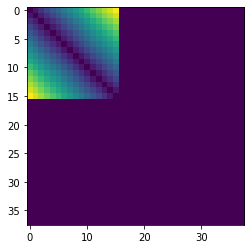

In [24]:
plt.imshow(padded_images[5])

In [25]:
len(padded_images)

163376

In [26]:
len(labels)

163376

# Train/val set split

In [19]:
x_train, x_val, y_train, y_val = sk.model_selection.train_test_split(distance_list, labels, test_size = 0.1, random_state = 23112021)

In [23]:
x_train = x_train[:,:,:,np.newaxis]
x_val = x_val[:,:,:,np.newaxis]

# Architecture

In [24]:
#Importing library
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [25]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(38,38,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(38,38,1,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(1))


#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 5, 5, 256)         0

# Callbacks

In [34]:
import wandb

In [35]:
wandb.init(project="prot_alphafold2_prot", entity="jlrestrepol")

2021-11-24 16:22:07.668250: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Trainig

In [36]:
from wandb.keras import WandbCallback

In [37]:
AlexNet.compile(loss = "mean_squared_error", optimizer= 'adam')

In [38]:
AlexNet.fit(x_train, y_train, epochs = 30, validation_data = (x_val, y_val), callbacks = [WandbCallback()])

Epoch 1/30
366/366 [==============================] - 7s 15ms/step - loss: 133.0867 - val_loss: 135.8721
Epoch 2/30
366/366 [==============================] - 5s 13ms/step - loss: 131.2732 - val_loss: 136.8144
Epoch 3/30
366/366 [==============================] - 5s 13ms/step - loss: 132.5317 - val_loss: 137.7498
Epoch 4/30
366/366 [==============================] - 5s 14ms/step - loss: 130.1494 - val_loss: 138.2616
Epoch 5/30
366/366 [==============================] - 5s 14ms/step - loss: 138.6598 - val_loss: 138.3159
Epoch 6/30
366/366 [==============================] - 5s 14ms/step - loss: 138.1105 - val_loss: 137.3206
Epoch 7/30
366/366 [==============================] - 5s 14ms/step - loss: 133.4433 - val_loss: 141.2251
Epoch 8/30
366/366 [==============================] - 5s 14ms/step - loss: 130.9302 - val_loss: 135.7746
Epoch 9/30
366/366 [==============================] - 5s 12ms/step - loss: 133.0286 - val_loss: 136.3829
Epoch 10/30
366/366 [==============================] - 

In [33]:
wandb.finish()

AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

# FCN

In [22]:
shapes = np.array(list(map(lambda x: x.shape[0], distance_list)))
idx = [e >= 9 for e in shapes]

In [23]:
distance_sublist = np.array(distance_list, dtype=object)[idx].tolist()
labels_sublist = labels[idx]

In [24]:
x_train, x_val, y_train, y_val = sk.model_selection.train_test_split(distance_sublist, labels_sublist, test_size = 0.1, random_state = 23112021)

In [25]:
len(x_val)

15094

## Architecture

In [27]:

def FCN_model(len_classes=1, dropout_rate=0.5):
    
    inputs = tf.keras.layers.Input(shape=(None, None, 1))

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(inputs)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    #x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=2)(x)
    #x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Activation('relu')(x)

    # Uncomment the below line if you're using dense layers
    # x = tf.keras.layers.GlobalMaxPooling2D()(x)

    # Fully connected layer 1
    # x = tf.keras.layers.Dropout(dropout_rate)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=64)(x)
    # x = tf.keras.layers.Activation('relu')(x)

    # Fully connected layer 1
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Fully connected layer 2
    # x = tf.keras.layers.Dropout(dropout_rate)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=len_classes)(x)
    # predictions = tf.keras.layers.Activation('softmax')(x)

    # Fully connected layer 2
    x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    
    print(model.summary())
    print(f'Total number of layers: {len(model.layers)}')

    return model

In [29]:
fcn = FCN_model()
optimizer = tf.keras.optimizers.Adam(lr=0.001)
fcn.compile(loss = "mean_squared_error", optimizer= optimizer)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    320       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
activation_6 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
activation_7 (Activation)    (None, None, None, 64)    0   

In [30]:
predicted = np.zeros_like(y_val, dtype = "float32")
for j, (image, label) in enumerate(zip(x_val, y_val)):
    image = image[np.newaxis,:,:,np.newaxis].astype("float32")
    predicted[j] = fcn(image, training = False)
error = tf.losses.mean_squared_error(predicted, y_val).numpy()
f'The initial validation error is {error}'

2021-11-30 19:09:34.944848: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-11-30 19:09:35.610879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-11-30 19:09:36.404136: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-30 19:09:37.009633: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-11-30 19:09:37.034531: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


'The initial validation error is 183060.83007292022'

In [31]:
batch_size = 64
for epoch in np.arange(10):
    print(f"epoch {epoch}. Training")
    total_loss = 0

    # get trainable variables
    train_vars = fcn.trainable_variables
    # Create empty gradient list (not a tf.Variable list)
    accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
    
    for i, (image, label) in enumerate(zip(x_train, y_train)):
        image = image[np.newaxis,:,:,np.newaxis].astype("float64")
        label = np.array(label).reshape(1,-1).astype("float64")
        with tf.GradientTape() as tape:
            logits = fcn(image, training = True)
            loss = tf.losses.mean_squared_error(label, logits)
            #loss = tf.compat.v1.losses.absolute_difference(label, logits)
        total_loss += loss
        grads = tape.gradient(loss, fcn.trainable_weights)
        # Accumulate the gradients
        #print(accum_gradient[0][0,0,0,16])
        accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, grads)]
        
        if (i%batch_size==0) or (len(x_train) - i == 1):
            accum_gradient = [this_grad/batch_size for this_grad in accum_gradient]
            optimizer.apply_gradients(zip(accum_gradient, train_vars))
            
            # Create empty gradient list (not a tf.Variable list)
            accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
            continue
        
        if i%50000 == 0:
            print(f'Datapoint {i}')
            

    predicted = np.zeros_like(y_val, dtype = "float32")
    for j, (image, label) in enumerate(zip(x_val, y_val)):
        image = image[np.newaxis,:,:,np.newaxis].astype("float32")
        predicted[j] = fcn(image, training = False)
    error = tf.losses.mean_squared_error(predicted, y_val).numpy()

    print(f'Epoch loss = {total_loss / len(x_train)}. Validation loss = {error}')

epoch 0. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [10031.44]. Validation loss = 76787.36345025743
epoch 1. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [7649.9243]. Validation loss = 74063.82554119933
epoch 2. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [7553.078]. Validation loss = 71944.23759872821
epoch 3. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [7549.297]. Validation loss = 70902.54218914983
epoch 4. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [7443.5483]. Validation loss = 69695.84258199029
epoch 5. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [7472.881]. Validation loss = 67975.59568093087
epoch 6. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [7467.137]. Validation loss = 69444.54810679719
epoch 7. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [7386.5566]. Validation loss = 71297.02776488179
epoch 8. Training
Datapoint 50000
Datapoint 100000
Epoch loss = [7465.851]. Validation loss = 66171.0